In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the LG fitted simulation to a PCA/UMAP to check the viz

In [2]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
#PATH = f'../data/connectomes/brain_graph/'
DATASET = f'multiple_datasets'
#DATASET = f'repeated_10_scale_60'
PATH = f'runs/fitting_results_braingraph_'

files = sorted(os.listdir(PATH+DATASET))
files

['df_graph_attr_0.parquet',
 'df_graph_attr_20.parquet',
 'model_comparison_results.pkl']

In [5]:
parquet_files = [f for f in files if f.endswith('.parquet')]
df_list = [pd.read_parquet(PATH+DATASET+'/'+file) for file in parquet_files]
df_all_results = pd.concat(df_list, ignore_index=True)

In [6]:
df_all_results.shape,display(df_all_results.head())

,graph_id,model,gic_value,fit_success,degree_centrality_mean,degree_centrality_std,betweenness_centrality_mean,betweenness_centrality_std,closeness_centrality_mean,closeness_centrality_std,...,eigenvector_centrality_std,clustering_coefficient_mean,clustering_coefficient_std,average_path_length,diameter,density,transitivity,assortativity,number_of_components,largest_component_size
0,1,Original,NaN,True,0.213047,0.134864,0.008740,0.020582,0.395417,0.167450,...,0.057261,0.674047,0.318777,1.942488,4,0.213047,0.654267,-0.119291,12,72
1,1,LG,0.890106,True,0.221275,0.041739,0.009781,0.003915,0.558525,0.017609,...,0.021257,0.213242,0.028827,1.792242,3,0.221275,0.212750,-0.005080,1,83
2,1,WS,0.042095,True,0.219512,0.034493,0.009726,0.003443,0.559629,0.012807,...,0.016833,0.211020,0.031745,1.787834,3,0.219512,0.209040,-0.054344,1,83
3,1,BA,0.660101,True,0.024096,0.032458,0.043299,0.122713,0.231290,0.047252,...,0.091333,0.000000,0.000000,4.507200,10,0.024096,0.000000,-0.318951,1,83
4,1,ER,2.905486,True,0.898619,0.032620,0.001252,0.000102,0.908749,0.026962,...,0.003920,0.898436,0.002400,1.101381,2,0.898619,0.898411,-0.017399,1,83


((240, 21), None)

In [7]:
df_all_results.columns.tolist()

['graph_id',
 'model',
 'gic_value',
 'fit_success',
 'degree_centrality_mean',
 'degree_centrality_std',
 'betweenness_centrality_mean',
 'betweenness_centrality_std',
 'closeness_centrality_mean',
 'closeness_centrality_std',
 'eigenvector_centrality_mean',
 'eigenvector_centrality_std',
 'clustering_coefficient_mean',
 'clustering_coefficient_std',
 'average_path_length',
 'diameter',
 'density',
 'transitivity',
 'assortativity',
 'number_of_components',
 'largest_component_size']

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# We are only interested in fit_success = True
df_plot = df_all_results[df_all_results['fit_success']==True].copy()

# Select features, we will use all numeric columns except graph_id and gic_value
features = df_plot.select_dtypes(include=np.number).columns.tolist()
if 'graph_id' in features:
    features.remove('graph_id')
# if 'gic_value' in features:
#     features.remove('gic_value')




# Target for coloring
target = 'model'

if 'gic_value' in features:
    df_plot['gic_value'] = df_plot['gic_value'].fillna(0)

X = df_plot[features]
y = df_plot[target]

# Check for NaN values and handle them
if X.isnull().sum().sum() > 0:
    print("NaN values found in features. Filling with median.")
    X = X.fillna(X.median())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# --- PCA ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [10]:
# --- UMAP ---
try:
    import umap
except ImportError:
    print("UMAP not found. Please install it using: pip install umap-learn")
    X_umap = np.zeros_like(X_pca) # Placeholder
else:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# --- t-SNE ---
# It may take a while to run t-SNE on large datasets
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)


In [12]:
# Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca[target] = y.values

df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap[target] = y.values

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne[target] = y.values


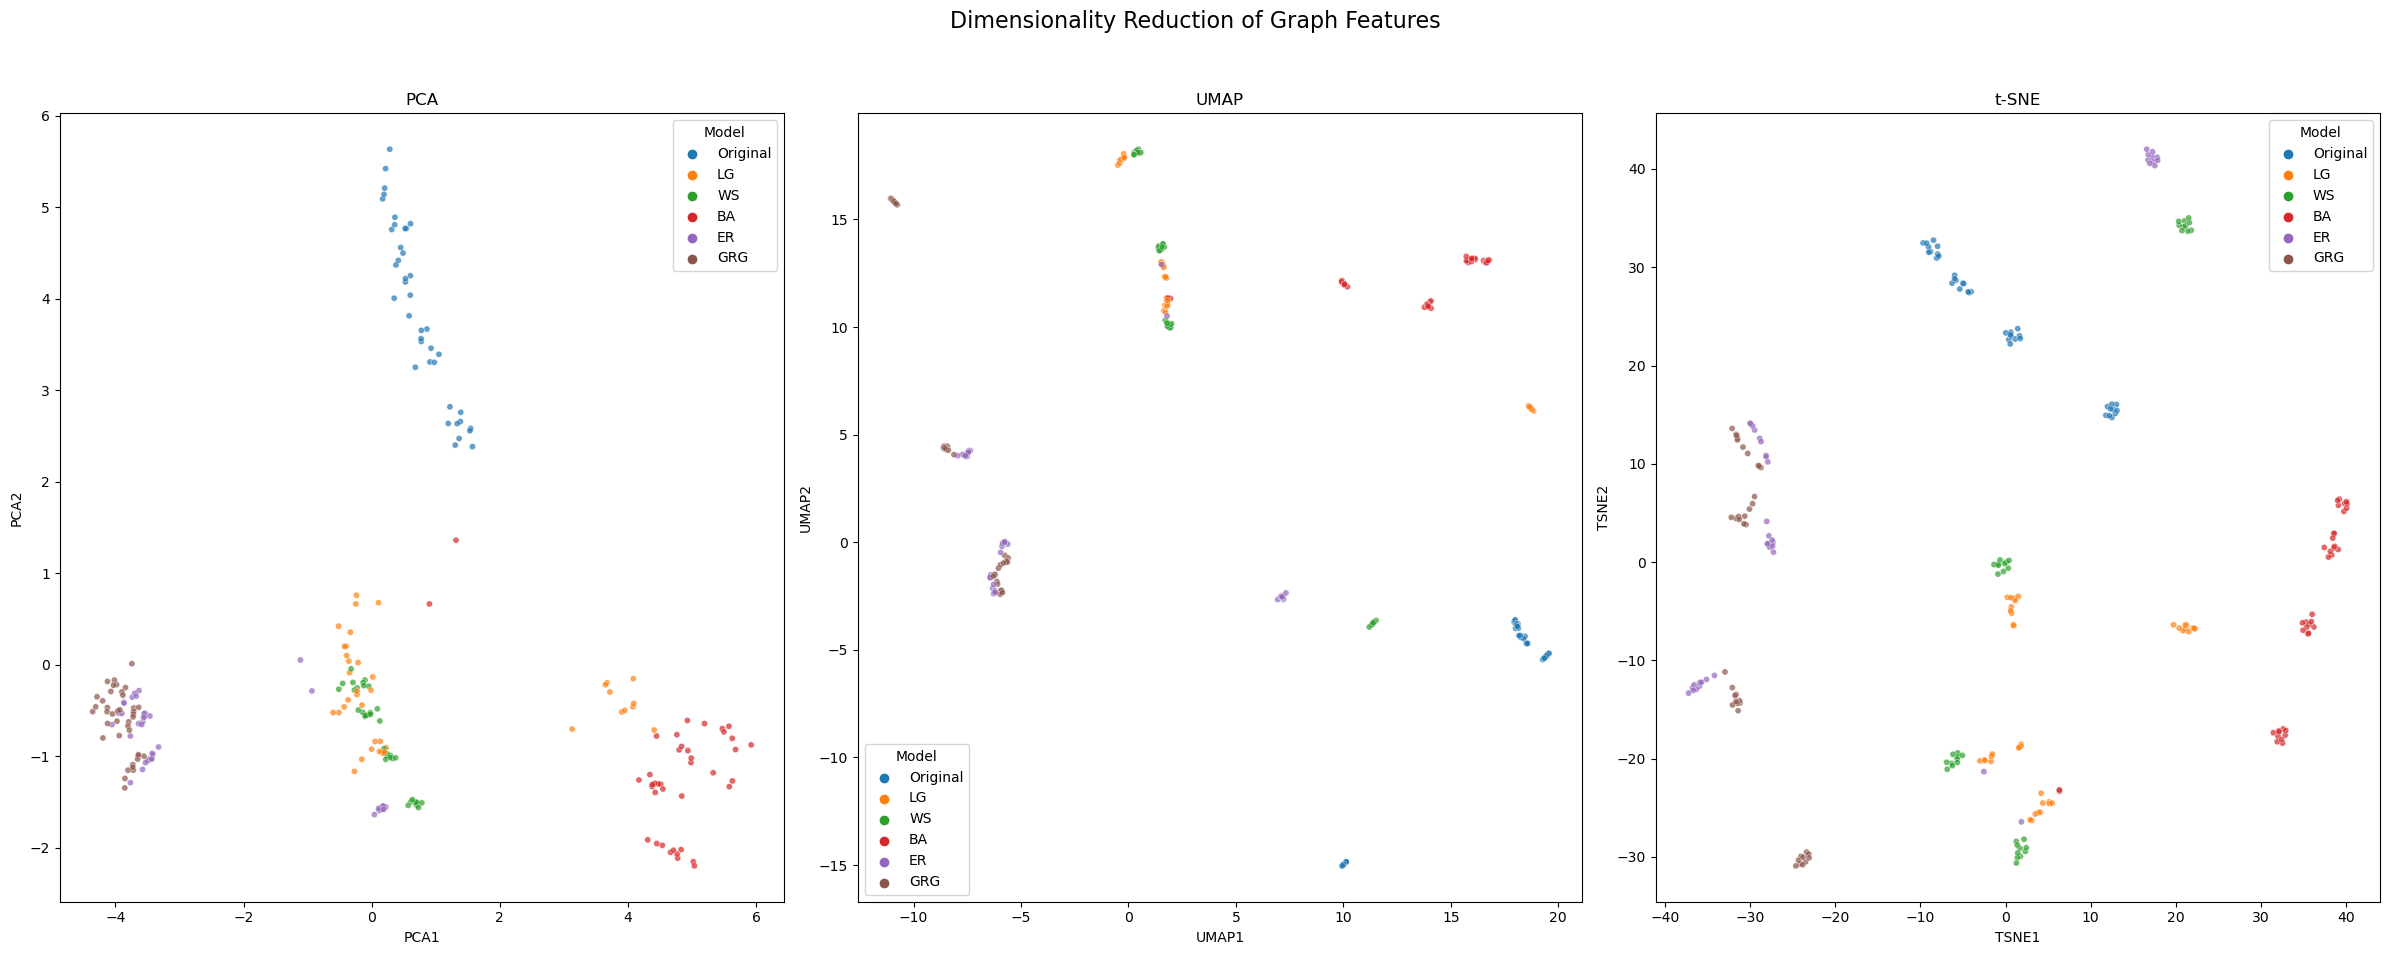

In [13]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(24, 10))
fig.suptitle('Dimensionality Reduction of Graph Features', fontsize=16)

# PCA Plot
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue=target, ax=axes[0], alpha=0.7, s=20)
axes[0].set_title('PCA')
axes[0].legend(title='Model')

# UMAP Plot
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue=target, ax=axes[1], alpha=0.7, s=20)
axes[1].set_title('UMAP')
axes[1].legend(title='Model')

# t-SNE Plot
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue=target, ax=axes[2], alpha=0.7, s=20)
axes[2].set_title('t-SNE')
axes[2].legend(title='Model')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()